In [1]:
# CNN
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

# others
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import time

# dataset
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import Flowers102
from sklearn.metrics import f1_score


# read file 
import pandas as pd

# label
from scipy.io import loadmat
import json
from tqdm import tqdm
from itertools import islice
from typing import List, Dict, Tuple

# Use TweetEval emotion recognition dataset 

In [2]:
# root = '../../Data/tweeteval/datasets/emotion/'
# mapping_file = os.path.join(root, 'mapping.txt')
# test_labels_file = os.path.join(root, 'test_labels.txt')
# test_text_file = os.path.join(root, 'test_text.txt')
# train_labels_file = os.path.join(root, 'train_labels.txt')
# train_text_file = os.path.join(root, 'train_text.txt')
# val_labels_file = os.path.join(root, 'val_labels.txt')
# val_text_file = os.path.join(root, 'val_text.txt')

In [3]:
# mapping_pd = pd.read_csv(mapping_file, sep='\t', header=None)
# test_label_pd = pd.read_csv(test_labels_file, sep='\t', header=None)
# test_dataset = open(test_text_file).read().split('\n')[:-1] # remove last empty line 
# train_label_pd = pd.read_csv(train_labels_file, sep='\t', header=None)
# train_dataset = open(train_text_file).read().split('\n')[:-1] # remove last empty line
# val_label_pd = pd.read_csv(val_labels_file, sep='\t', header=None)
# val_dataset = open(val_text_file).read().split('\n')[:-1] # remove last empty line

# Preprocess training data
- Given: Notes with ranges and labels
- Transform into label + lists of tokens with [does token describe label]

In [4]:
root = './data/'
features_path = os.path.join(root, 'features.csv')
patient_notes_path = os.path.join(root, 'patient_notes.csv')
sample_submission_path = os.path.join(root, 'sample_submission.csv')
test_path = os.path.join(root, 'test.csv')
train_path = os.path.join(root, 'train.csv')
features = pd.read_csv(features_path, sep=',', header=0)
patient_notes = pd.read_csv(patient_notes_path, sep=',', header=0)
train_raw = pd.read_csv(train_path, sep=',', header=0)


In [5]:
# unusual_numbers = features["feature_num"].value_counts()[features["feature_num"].value_counts() != 1]
# unusual_numbers
features[features["feature_text"] == "Female"]
# features["feature_num"] == 

,feature_num,case_num,feature_text
25,112,1,Female
34,208,2,Female
66,407,4,Female
70,501,5,Female
99,700,7,Female
110,802,8,Female
139,913,9,Female


## intro 
- `case_num`: 0~9, each num belongs their groups ... ? 
- `pn_num`: the id in patient_notes.csv which is 'pn_history', present the note of each case 
- `feature_num`: the id in features.csv which is 'feature_num', present the feature of each case 
- `location`: 

In [6]:
import re
def df_string2list_of_ints(df_string: str):
    df_string = df_string.strip("[]")
    if df_string == "":
        return []
    entries = re.split(",|;", df_string)
    entries = [entry.strip(" '") for entry in entries]
    ranges = [tuple(int(num_as_str) for num_as_str in entry.split(" ")) for entry in entries]
    return ranges

In [7]:
train_raw

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']
...,...,...,...,...,...,...
14295,95333_912,9,95333,912,[],[]
14296,95333_913,9,95333,913,[],[]
14297,95333_914,9,95333,914,['photobia'],['274 282']
14298,95333_915,9,95333,915,['no sick contacts'],['421 437']


In [8]:
data_merged = train_raw.merge(features, on=['feature_num', 'case_num'], how='left')
data_merged = data_merged.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
data_merged["location"] = data_merged["location"].apply(df_string2list_of_ints)
data_merged.head()

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history
0,00016_000,0,16,0,['dad with recent heart attcak'],"[(696, 724)]",Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...
1,00016_001,0,16,1,"['mom with ""thyroid disease']","[(668, 693)]",Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...
2,00016_002,0,16,2,['chest pressure'],"[(203, 217)]",Chest-pressure,HPI: 17yo M presents with palpitations. Patien...
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","[(70, 91), (176, 183)]",Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...
4,00016_004,0,16,4,['felt as if he were going to pass out'],"[(222, 258)]",Lightheaded,HPI: 17yo M presents with palpitations. Patien...


In [9]:
train = data_merged[["feature_text", "pn_history", "location", ]]
train.head()

,feature_text,pn_history,location
0,Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...,"[(696, 724)]"
1,Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...,"[(668, 693)]"
2,Chest-pressure,HPI: 17yo M presents with palpitations. Patien...,"[(203, 217)]"
3,Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...,"[(70, 91), (176, 183)]"
4,Lightheaded,HPI: 17yo M presents with palpitations. Patien...,"[(222, 258)]"


In [10]:
# filter training data with no location
train = train[train["location"].apply(lambda row: len(row) != 0)]

In [11]:
print(f'Size of dataset= {len(train)}')

Size of dataset= 9901


## Tokenization
- Use spaCy to split the notes into words.

Before start using spaCy
```
conda install -c conda-forge spacy
python -m spacy download en_core_web_sm
```

In [12]:
from typing import Iterable
# from pytorch_pretrained_bert import BertTokenizer

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [13]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenizer.encode_plus("hello i am Drunk", return_offsets_mapping=True, add_special_tokens=True)

c:\Users\Leonard\.conda\envs\UniAILab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
from os.path import join as pathjoin
import pickle
cache_dir = "cache"

In [15]:
tokenizer.encode_plus("hello i am Drunk", return_offsets_mapping=True, add_special_tokens=True)

{'input_ids': [101, 7592, 1045, 2572, 7144, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 5), (6, 7), (8, 10), (11, 16), (0, 0)]}

In [16]:
from pytorch_pretrained_bert.modeling import BertModel
BERT_FP = ('bert-base-uncased')

In [17]:
def get_bert_embed_matrix():
    bert = BertModel.from_pretrained(BERT_FP)
    bert_embeddings = list(bert.children())[0]
    bert_word_embeddings = list(bert_embeddings.children())[0]
    mat = bert_word_embeddings.weight.data.numpy()
    return mat

In [18]:
embedding_matrix = get_bert_embed_matrix()

In [19]:
embedding_matrix.shape

(30522, 768)

In [20]:
from functools import cache, lru_cache

def embed_seq(s: Iterable[int]):
    return np.array([onehot_word(word_id) @ embedding_matrix for word_id in s])

@lru_cache(maxsize=10000)
def embed_word(word_id: int):
    return onehot_word(word_id) @ embedding_matrix

def onehot_word(a: int):
    oh = np.zeros(30522, dtype=int)
    oh[a] = 1
    return oh

In [21]:
from typing import Dict, List

cache_file = pathjoin(cache_dir, "tokenized_pn_histories.pkl")
if os.path.isfile(cache_file):
    with open(cache_file, "rb") as f:
        tokenized_pn_histories = pickle.load(f)
    print("Tokenized patient histories loaded from cache.")
else:
    print("Found no cached tokenized patient histories. Tokenizing...")
    tokenized_pn_histories: Dict[str, List[Dict]] = {}
    for pn_history in tqdm(train["pn_history"]):
        indexed_words = []
        if pn_history in tokenized_pn_histories:
            continue

        tokenized = tokenizer.encode_plus(pn_history, return_offsets_mapping=True, add_special_tokens=True)

        for word, offset_mapping in zip(tokenized["input_ids"], tokenized["offset_mapping"]):
            embedded_token = embed_word(word)

            indexed_words.append({
                "word_id": word,
                "embedded": embedded_token,
                "range": offset_mapping
            })
                    
        tokenized_pn_histories[pn_history] = indexed_words
    with open(cache_file, "wb") as f:
        pickle.dump(tokenized_pn_histories, f)


Tokenized patient histories loaded from cache.


Data structure:
tokenized_pn_histories
hist_id -> [tokens]
token -> ['word_id', 'embedded', 'range']


In [22]:
# list(tokenized_pn_histories.values())[0][0].keys()
list(tokenized_pn_histories.values())[0][1]

{'word_id': 6522,
 'embedded': array([-0.01908113, -0.04173963, -0.06673449, -0.01592105,  0.04393673,
        -0.0045615 , -0.07181855, -0.03923002, -0.06660692, -0.05208729,
        -0.05683259, -0.07923082, -0.07103121, -0.03811198,  0.04058741,
        -0.07675945, -0.03249264,  0.01277649,  0.00591493, -0.02265794,
        -0.07537558, -0.0377069 , -0.02679249, -0.02630543, -0.10752729,
        -0.07387543, -0.03104966, -0.05502456, -0.01574389,  0.03902053,
        -0.03393734, -0.04892192, -0.01713544, -0.01373354, -0.03406208,
        -0.03928473, -0.01480401, -0.0745343 , -0.04668886,  0.04388529,
         0.04298296, -0.02789518, -0.06555539, -0.01023453, -0.05270426,
        -0.01351104, -0.01696531, -0.02604903, -0.06805495, -0.0114427 ,
        -0.07451096, -0.08470455, -0.06320265, -0.07705162,  0.00924673,
        -0.06076133, -0.03972978, -0.00976295,  0.04022013,  0.00853729,
        -0.03172083, -0.07831176, -0.04030865, -0.01483213, -0.02548516,
        -0.02037099, 

In [23]:
from typing import Dict, List

cache_file = pathjoin(cache_dir, "tokenized_features.pkl")
if os.path.isfile(cache_file):
    with open(cache_file, "rb") as f:
        tokenized_features = pickle.load(f)
    print("Tokenized features loaded from cache.")
else:
    print("Found no cached tokenized features. Tokenizing...")
    tokenized_features: Dict[str, List[str]] = {}
    for feature_text in tqdm(train["feature_text"]):
        indexed_words = []
        if feature_text in tokenized_features:
            continue

        tokenized = tokenizer.encode_plus(feature_text, add_special_tokens=True)

        for word in tokenized["input_ids"]:
            embedded_token = embed_word(word)

            indexed_words.append({
                "word_id": word,
                "embedded": embedded_token,
            })
                
        tokenized_features[feature_text] = indexed_words
    with open(cache_file, "wb") as f:
        pickle.dump(tokenized_features, f)


Tokenized features loaded from cache.


In [24]:
list(tokenized_features.values())[0][1]

{'word_id': 2155,
 'embedded': array([ 1.52311306e-02,  9.42442659e-03, -3.38619053e-02, -2.42799595e-02,
         2.34256983e-02, -8.17641430e-03, -2.93032657e-02, -5.23912981e-02,
         3.92839797e-02,  2.82708416e-03, -1.66527238e-02, -2.51747109e-02,
        -3.52113359e-02,  3.62591706e-02, -7.53024034e-03,  2.13038772e-02,
        -2.84320372e-03, -5.02108894e-02, -3.15106139e-02, -1.20872613e-02,
        -3.53940949e-02, -3.89684625e-02, -9.54788644e-03,  1.48558039e-02,
        -1.46783004e-02,  4.23340984e-02, -1.99949723e-02,  8.76626652e-03,
        -2.45130006e-02, -5.38146645e-02,  2.60462761e-02, -1.56000787e-02,
        -3.20293419e-02, -1.68701317e-02, -5.71791418e-02,  6.56096172e-03,
        -2.73210574e-02, -9.99859255e-03, -2.09460687e-02,  1.66101735e-02,
         2.68947575e-02,  1.13374833e-03, -1.66690629e-02,  1.36123579e-02,
         2.36188024e-02, -7.47381104e-03,  1.41381836e-02,  1.25802001e-02,
         2.57711634e-02,  1.62442252e-02, -3.19506996e-03,

- Follow the example described here. Use the same architecture, but:
  - only use the last output of the LSTM in the loss function
  - use an embedding dim of 128
  - use a hidden dim of 256.  

## Get feature-relevancy of tokens via char ranges

In [25]:
train_data_preprocessed = dict()
for i, (feature_text, pn_history, location) in tqdm(train.iterrows()):
    tokenized_history = tokenized_pn_histories[pn_history]
    tokens_with_scores = []
    for token in tokenized_history:
        percentages = []
        for feature_relevant_range in location:
            token_start, token_end = token["range"]
            range_start, range_end = feature_relevant_range[0], feature_relevant_range[1]
            
            percentage_of_token_in_range = max(min(token_end, range_end)+1 - max(token_start, range_start), 0) / (token_end+1 - token_start)
            percentages.append(percentage_of_token_in_range)
            # if percentage_of_token_in_range > 0:
            #     print(percentage_of_token_in_range, token, feature_relevant_range)
        

        tokens_with_scores.append({"token": token,
                                   "score": int(max(percentages) > 0.9)})

    train_data_preprocessed[i] = {
                                    "pn_history_tokens": [ts["token"] for ts in tokens_with_scores],
                                    "scores": torch.tensor([ts["score"] for ts in tokens_with_scores]),
                                    "feature_tokens": tokenized_features[feature_text],
                                    "locations": location
                                   }
        

9901it [00:11, 860.53it/s] 


In [26]:
num_no_positives = sum([1 for dp in train_data_preprocessed.values() if sum(dp["scores"]) == 0])
print(f"filtering {num_no_positives} out of {len(train_data_preprocessed)} datapoints because they don't contain any positive scores.")
train_data_preprocessed = {key: dp for key, dp in train_data_preprocessed.items() if sum(dp["scores"]) != 0}

filtering 2 out of 9901 datapoints because they don't contain any positive scores.


# Structure of the Model
Layers in LSTM Model:
1. embed feature tokens
2. lstm feature -> constant size vector

3. pass to 2nd lstm
	

In [27]:
EMBEDDING_DIM = embedding_matrix.shape[1]
HIDDEN_DIM = 256

In [28]:
class LSTMTokenScorer(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, dropout=0.0):
        super(LSTMTokenScorer, self).__init__()

        self.pn_history_hidden_dim = hidden_dim

        # self.bert_embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix))

        self.feature_lstm = nn.LSTM(embedding_dim, embedding_dim, bidirectional=False, dropout=dropout) # the feature is now one tensor of size [embedding_dim].

        self.total_lstm = nn.LSTM(embedding_dim * 2, self.pn_history_hidden_dim, bidirectional=False, dropout=dropout)
        
        self.hidden2score = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, pn_history, feature):
        # feature_embeds = self.bert_embedding(feature)
        feature_lstm_out, _ = self.feature_lstm(feature.view(len(feature), 1, -1)) # the feature is now one tensor of size [embedding_dim].
        feature_reduced = torch.squeeze(feature_lstm_out[-1]) #.view(1, -1)
        feature_multiplied = feature_reduced.repeat((len(pn_history), 1)) # duplicate feature vector to be same size as embedded pn_history vector.

        # pn_history_embeds = self.bert_embedding(pn_history)
        pn_history_and_features = torch.concat((feature_multiplied, pn_history), dim=1)

        pn_history_reduced, _ = self.total_lstm(pn_history_and_features)
        pred_score_raw = torch.squeeze(self.hidden2score(pn_history_reduced))
        pred_score = self.sigmoid(pred_score_raw)
        return pred_score

In [29]:
# all_scores = [d["scores"].numpy() for d in train_data_preprocessed.values()]
# avg_neg_div_pos = np.mean([(scores.shape[0] - np.sum(scores)) / np.sum(scores) for scores in all_scores])

In [30]:
train_data_preprocessed[0].keys()

dict_keys(['pn_history_tokens', 'scores', 'feature_tokens', 'locations'])

In [31]:
# feature_tokens = train_data_preprocessed[0]["feature_tokens"]
# pn_history_tokens = train_data_preprocessed[0]["pn_history_tokens"]

# feature_tensor = torch.tensor(np.array([t["embedded"] for t in feature_tokens]), dtype=torch.float)
# pn_history_tensor = torch.tensor(np.array([t["embedded"] for t in pn_history_tokens]), dtype=torch.float)

# model(pn_history_tensor, feature_tensor)

In [32]:
# From https://www.kaggle.com/theoviel/evaluation-metric-folds-baseline

def micro_f1(preds, truths):
    """
    Micro f1 on binary arrays.

    Args:
        preds (list of lists of ints): Predictions.
        truths (list of lists of ints): Ground truths.

    Returns:
        float: f1 score.
    """
    # Micro : aggregating over all instances
    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    return f1_score(truths, preds)


def spans_to_binary(spans, length=None):
    """
    Converts spans to a binary array indicating whether each character is in the span.

    Args:
        spans (list of lists of two ints): Spans.

    Returns:
        np array [length]: Binarized spans.
    """
    length = np.max(spans) if length is None else length
    binary = np.zeros(length)
    for start, end in spans:
        binary[start:end] = 1
    return binary


def span_micro_f1(preds: List[List[Tuple[int, int]]], truths: List[List[Tuple[int, int]]]):
    """
    Micro f1 on spans.

    Args:
        preds (list of lists of two ints): Prediction spans.
        truths (list of lists of two ints): Ground truth spans.

    Returns:
        float: f1 score.
    """
    bin_preds = []
    bin_truths = []
    for pred, truth in zip(preds, truths):
        if not len(pred) and not len(truth):
            continue
        length = max(np.max(pred) if len(pred) else 0, np.max(truth) if len(truth) else 0)
        bin_preds.append(spans_to_binary(pred, length))
        bin_truths.append(spans_to_binary(truth, length))
    return micro_f1(bin_preds, bin_truths)


In [33]:
span_micro_f1([[(1,3)]], [[(1,3)]])

1.0

In [34]:
def scored_ranges2spans(rnges: Tuple[int, int], scores: int) -> List[Tuple[int, int]]:
    thresh = 0.9
    spans: List[Tuple[int, int]] = []
    active_span_start = None
    active_span_end = None
    for rng, score in zip(rnges, scores):
        if active_span_start is None:
            if score > thresh:
                active_span_start = rng[0]
                active_span_end = rng[1]
        else: # prev. words are already part of span
            if score > thresh:
                active_span_end = rng[1]
            else:
                spans.append((active_span_start, active_span_end))
                active_span_start = None
                active_span_end = None
    if active_span_start is not None:
        spans.append((active_span_start, active_span_end))
    return spans
        

In [35]:
3172 in train_data_preprocessed.keys()

True

In [36]:
import random
logfile_name = "training_log.txt"
from sklearn.metrics import f1_score

def log(logtext: str = "") -> None:
    print(logtext)
    with open(logfile_name, "a", encoding="utf8") as f:
        f.write(str(logtext) + "\n")
    

def train_model(model: LSTMTokenScorer, criterion, optimizer, scheduler, num_epochs=1, prev_losses=[], prev_f1s=[]):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_f1 = 0.0
        best_loss = 9999999999999

        losses = prev_losses
        f1s = prev_f1s
        for epoch in range(num_epochs):
            log(f'Epoch {epoch}/{num_epochs - 1}')
            log('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()
                else: 
                    model.eval()
                
                running_loss = 0.0
                running_loss_average = 0.0
                running_f1_total = 0.0
                running_f1_average = 0.0
                num_non_zero_outputs_in_epoch = 0.0

                # batch = random.choices(list(train_data_preprocessed.values()), k=64)
                data_ids = list(train_data_preprocessed.keys())
                random.shuffle(data_ids)

                # Iterate over data.
                for i, data_id in enumerate(data_ids):
                    datum_preprocessed = train_data_preprocessed[data_id]
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    pn_history_tokens = datum_preprocessed["pn_history_tokens"]
                    scores = datum_preprocessed["scores"]
                    feature_tokens = datum_preprocessed["feature_tokens"]

                    feature_tensor = torch.tensor(np.array([t["embedded"] for t in feature_tokens]), dtype=torch.float)
                    pn_history_tensor = torch.tensor(np.array([t["embedded"] for t in pn_history_tokens]), dtype=torch.float)

                    # track history only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(pn_history_tensor, feature_tensor)
                        
                        num_non_zero_outputs = np.count_nonzero(outputs.detach().numpy().round().astype(int))
                        num_non_zero_outputs_in_epoch += num_non_zero_outputs
                        
                        loss = criterion(outputs.float(), scores.float())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    try:
                        f1 = f1_score(scores.int(), outputs.detach().round().int())
                    except Exception as e:
                        log("F1 score calc failed:")
                        log("Scores:")
                        log(scores.int())
                        log("\nOutputs")
                        log(outputs.detach().round().int())
                        log("\n")
                        raise Exception(e)
                    # statistics
                    running_loss += loss.item()
                    running_loss_average = running_loss / (i + 1)
                    losses.append(loss.item())
                    running_f1_total += f1
                    running_f1_average = running_f1_total / (i + 1)
                    f1s.append(f1)
                    
                    if i % 1000 == 0:
                        log(f"Epoch {epoch}, i={i}, avg. loss={running_loss_average}, avg. F1={running_f1_average}, nonzero outputs={num_non_zero_outputs_in_epoch}")
                        # log("LSTM output:")
                        # log(outputs)
                        # log("Truth:")
                        # log(scores)
                        log("Number of nonzero outputs (in sample prediction):")
                        log(num_non_zero_outputs)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss # / dataset_sizes[phase]
                epoch_f1 = running_f1_average # / dataset_sizes[phase]
                log(f'{phase} Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f} Time elapsed: {round((time.time() - since))} sec.')
                
                # deep copy the model
                if phase == 'test' and epoch_loss < best_loss: #epoch_acc > best_acc:
                    best_f1 = epoch_f1
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            log()

        time_elapsed = time.time() - since
        log(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        log(f'Best val Acc: {best_f1:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, losses, f1s


In [37]:
data_ids = list(train_data_preprocessed.keys())
neg_values = 0.0
pos_values = 0.0
for i, data_id in tqdm(enumerate(data_ids)):
    datum_preprocessed = train_data_preprocessed[data_id]

    pn_history_tokens = datum_preprocessed["pn_history_tokens"]
    scores = datum_preprocessed["scores"]
    pos_values += np.count_nonzero(scores.numpy().round().astype(int))
    neg_values += (scores.shape[0] - np.count_nonzero(scores.numpy().round().astype(int)))

neg_pos_ratio = neg_values / pos_values
neg_pos_ratio

9899it [00:00, 20773.41it/s]


43.99553335680338

In [38]:
from itertools import product

open(logfile_name, "w", encoding="utf8") # clear logs

for lr in [0.001]:
    # make model with vocab sizes, including placeholder indices
    model = LSTMTokenScorer(EMBEDDING_DIM, HIDDEN_DIM)
    # loss_function = nn.BCELoss()
    pos_weight = torch.full((1,), neg_pos_ratio)
    loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)#make positive class more valuable

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    log(f"Starting model training for lr={lr}...")
    model, losses, f1s = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs=20)

Starting model training for lr=0.001...
Epoch 0/19
----------


Epoch 0, i=0, avg. loss=1.0784095525741577, avg. F1=0.010204081632653062, nonzero outputs=195.0
Number of nonzero outputs (in sample prediction):
195
Epoch 0, i=1000, avg. loss=1.4001221967624737, avg. F1=0.002136226094267965, nonzero outputs=8222.0
Number of nonzero outputs (in sample prediction):
0
Epoch 0, i=2000, avg. loss=1.385379591862718, avg. F1=0.0010686468367627352, nonzero outputs=8222.0
Number of nonzero outputs (in sample prediction):
0
Epoch 0, i=3000, avg. loss=1.3825646156630726, avg. F1=0.0007125499234795845, nonzero outputs=8222.0
Number of nonzero outputs (in sample prediction):
0
Epoch 0, i=4000, avg. loss=1.374714329268926, avg. F1=0.000534456965849096, nonzero outputs=8222.0
Number of nonzero outputs (in sample prediction):
0
Epoch 0, i=5000, avg. loss=1.3708790938774602, avg. F1=0.00042758694668311, nonzero outputs=8222.0
Number of nonzero outputs (in sample prediction):
0
Epoch 0, i=6000, avg. loss=1.3723319926632978, avg. F1=0.0003563343310052046, nonzero outpu

In [39]:
# model, losses, f1s = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs=10,
#                                  prev_losses=losses,
#                                  prev_f1s=f1s)

In [43]:

with open(pathjoin(cache_dir, "losses2.pkl"), "wb") as f:
    pickle.dump(losses, f)
with open(pathjoin(cache_dir, "f1s2.pkl"), "wb") as f:
    pickle.dump(f1s, f)
    

In [41]:
losses[0]

1.0784095525741577

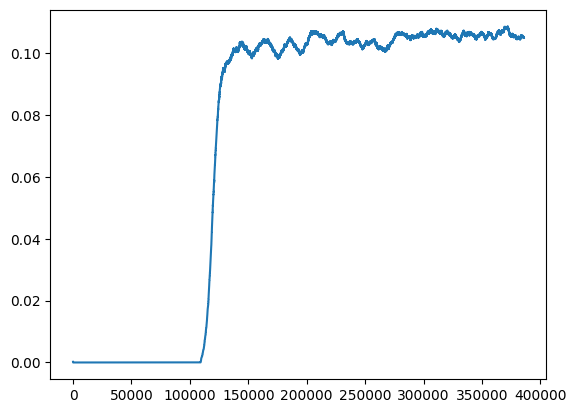

In [46]:
def smooth(x: Iterable, N: int = 10_000):
    return np.convolve(x, np.ones(N)/N, mode='valid')
    
plt.plot(smooth(f1s))